In [2]:
import sv_utils
import torch 
import numpy as np
import pylab as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure
from os.path import dirname, realpath
from singleNeuron_omega import preSpikes, nextSpikes, STDPLIFDensePopulation, convergence_level, get_metrics, get_metrics_long_pat

## Sequence Visualizer

El proposito de esta notebook es el poder graficar tanto la entrada como salida de la red DSNN que reconoce patrones en una secuencia de numeros aleatorios.

In [ ]:
Sin_tmp = np.load('./sequences/p_18/testing/15_0_0/layer_5_conv.pt')
print(Sin_tmp.shape)
Sin = np.reshape(Sin_tmp, (Sin_tmp.shape[0]*Sin_tmp.shape[1], Sin_tmp.shape[2]))
Sin = np.transpose(Sin)
print(Sin.shape)

### Tren de spikes de entrada

In [3]:
plt.rcParams["figure.figsize"] =(15,6)
#sv_utils.plotLIF(U=None, S=Sin[:200])
#print("Spikes: " + str(np.count_nonzero(Sin)))

### Tren de spikes de salida del ultimo layer de la arquitectura

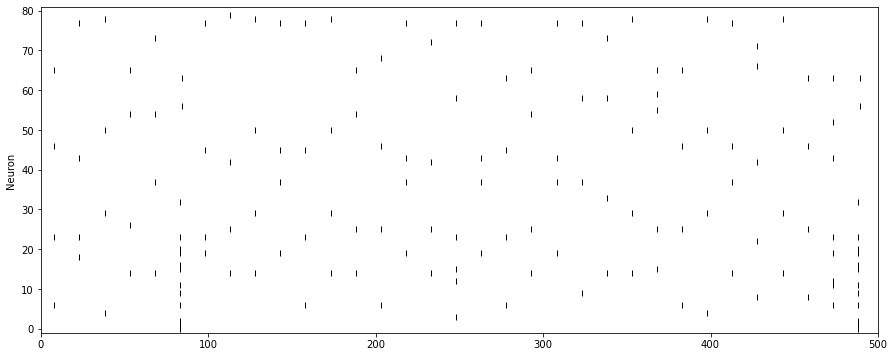

torch.Size([74985, 80])
Spikes: 25665


In [11]:
Sin_out_s = torch.load('./sequences/massive_runs/1/last_layer_results/all_nums_5/training/0/layer_5_conv.pt')
sv_utils.plotLIF(U=None, S=Sin_out_s[:500].data.numpy())
print(Sin_out_s.shape)
print("Spikes: " + str(np.count_nonzero(Sin_out_s)))

## Entrenamos a la capa FC con la salida de la arq

In [20]:
#pat_times = np.load('./sequences/p_18/training/pat_p_18.npy')
Sin = Sin_out_s.clone().detach()
T = Sin.shape[0]
N_out = 8
N_in = Sin.shape[1]
th = 3.5

FC_layer = STDPLIFDensePopulation(in_channels=N_in, out_channels=N_out,
                                        weight=0., alpha=float(np.exp(-1e-3/10e-3)),
                                        beta=float(np.exp(-1e-3/2e-5)), delay=0,
                                        th=th, omega=0.35, a_plus=.009125, a_minus=.0125625,
                                        w_max=1.)


# Pre-procesamos PSpikes y NSpikes
dt_ltp = 20  # Cantidad de timesteps que miro hacia atras
dt_ltd = 70  # Cantidad de timesteps que miro hacia delante
PSpikes = preSpikes(T, dt_ltp, torch.zeros(T, N_in), Sin)
NSpikes = nextSpikes(T, dt_ltd, torch.zeros(T, N_in), Sin)

# Realizamos el entrenamiento STDP
Uprobe_fc = np.empty([T, N_out])
Iprobe_fc = np.empty([T, N_out])
Sprobe_fc = np.empty([T, N_out])

n = 0
t = 0
c_l = 1.
while (c_l > 0.01) and (t < 400000):
    state = FC_layer.forward(Sin[n].unsqueeze(0), PSpikes[n], NSpikes[n-1])
    Uprobe_fc[n] = state.U.data.numpy()
    Iprobe_fc[n] = state.I.data.numpy()
    Sprobe_fc[n] = state.S.data.numpy()
    n += 1
    if n >= T:
        n = 0
    c_l = convergence_level(FC_layer.fc_layer.weight[0])
    t += 1
    if (t % 500) == 0:
        print("iter: " + str(t) + " convergence: " + str(c_l))
        
        
# Una vez finalizado el entrenamiento, obtenemos la salida sin entrenear
Uprobe_fc = np.empty([T, N_out])
Iprobe_fc = np.empty([T, N_out])
Sprobe_fc = np.empty([T, N_out])
for n in range(T):
    state = FC_layer.forward_no_learning(Sin[n].unsqueeze(0))
    Uprobe_fc[n] = state.U.data.numpy()
    Iprobe_fc[n] = state.I.data.numpy()
    Sprobe_fc[n] = state.S.data.numpy()


iter: 500 convergence: 0.16309702810827847
iter: 1000 convergence: 0.16387654542201538
iter: 1500 convergence: 0.16461976997800448
iter: 2000 convergence: 0.16546268496578528
iter: 2500 convergence: 0.16590833885027756
iter: 3000 convergence: 0.16616165404188407
iter: 3500 convergence: 0.16612511598051824
iter: 4000 convergence: 0.16673633096717602
iter: 4500 convergence: 0.16748165883567084
iter: 5000 convergence: 0.1679009151156206
iter: 5500 convergence: 0.16781913148141156
iter: 6000 convergence: 0.167513786142127
iter: 6500 convergence: 0.16734098001814057
iter: 7000 convergence: 0.1661012366788861
iter: 7500 convergence: 0.16566947044658184
iter: 8000 convergence: 0.16510810586243674
iter: 8500 convergence: 0.1643767287316365
iter: 9000 convergence: 0.16368371461290118
iter: 9500 convergence: 0.1631514109878108
iter: 10000 convergence: 0.16255172142871227
iter: 10500 convergence: 0.16139616581318852
iter: 11000 convergence: 0.16005466741996893
iter: 11500 convergence: 0.159299312

iter: 92500 convergence: 0.11290776787820658
iter: 93000 convergence: 0.1123696828989003
iter: 93500 convergence: 0.11228179330739911
iter: 94000 convergence: 0.11228972811428468
iter: 94500 convergence: 0.1121808245558766
iter: 95000 convergence: 0.11249052877141943
iter: 95500 convergence: 0.11175377825440747
iter: 96000 convergence: 0.11234442955395696
iter: 96500 convergence: 0.1118422606088545
iter: 97000 convergence: 0.11214501541241932
iter: 97500 convergence: 0.1117290874103288
iter: 98000 convergence: 0.11219157189292292
iter: 98500 convergence: 0.11201749774637601
iter: 99000 convergence: 0.11170473839143029
iter: 99500 convergence: 0.11173222091838544
iter: 100000 convergence: 0.11144400555741756
iter: 100500 convergence: 0.11095670816899875
iter: 101000 convergence: 0.1105492182040487
iter: 101500 convergence: 0.11039551787344606
iter: 102000 convergence: 0.11020944595530531
iter: 102500 convergence: 0.11089243504259279
iter: 103000 convergence: 0.1109306471187463
iter: 103

iter: 182500 convergence: 0.08913835567587235
iter: 183000 convergence: 0.08912631213331922
iter: 183500 convergence: 0.08880215550391735
iter: 184000 convergence: 0.08849514690350704
iter: 184500 convergence: 0.08856126645678325
iter: 185000 convergence: 0.08795236452158121
iter: 185500 convergence: 0.08799382934928177
iter: 186000 convergence: 0.0881918969777317
iter: 186500 convergence: 0.08879979320570452
iter: 187000 convergence: 0.08806453281817155
iter: 187500 convergence: 0.08760193713178842
iter: 188000 convergence: 0.08731503175807157
iter: 188500 convergence: 0.0872840662249765
iter: 189000 convergence: 0.08737212908987982
iter: 189500 convergence: 0.08786604091282976
iter: 190000 convergence: 0.08815759987779521
iter: 190500 convergence: 0.08722239171506312
iter: 191000 convergence: 0.08671589934901487
iter: 191500 convergence: 0.08707247414834038
iter: 192000 convergence: 0.08757025608326532
iter: 192500 convergence: 0.08690290759264269
iter: 193000 convergence: 0.08771431

iter: 272000 convergence: 0.07539113451558874
iter: 272500 convergence: 0.07629668598748038
iter: 273000 convergence: 0.07577844373027562
iter: 273500 convergence: 0.07611220695133611
iter: 274000 convergence: 0.076306345762002
iter: 274500 convergence: 0.07631190499802115
iter: 275000 convergence: 0.07584985233158778
iter: 275500 convergence: 0.07586352887831391
iter: 276000 convergence: 0.07495605213701106
iter: 276500 convergence: 0.07498138483458203
iter: 277000 convergence: 0.0749968185703437
iter: 277500 convergence: 0.07519030795514754
iter: 278000 convergence: 0.07503645082494236
iter: 278500 convergence: 0.07516168054860464
iter: 279000 convergence: 0.07527648180349789
iter: 279500 convergence: 0.0755524348883336
iter: 280000 convergence: 0.07544558589803016
iter: 280500 convergence: 0.0760024911094273
iter: 281000 convergence: 0.07541431085828147
iter: 281500 convergence: 0.07585917754703705
iter: 282000 convergence: 0.07563884445043242
iter: 282500 convergence: 0.07556288579

iter: 361500 convergence: 0.06858933097705906
iter: 362000 convergence: 0.0680114610837729
iter: 362500 convergence: 0.06735902865062657
iter: 363000 convergence: 0.06752185175957778
iter: 363500 convergence: 0.06793812742915488
iter: 364000 convergence: 0.06746229802913975
iter: 364500 convergence: 0.06750074053752397
iter: 365000 convergence: 0.06751251905985389
iter: 365500 convergence: 0.06663554561902747
iter: 366000 convergence: 0.0657293433880743
iter: 366500 convergence: 0.06615512517218645
iter: 367000 convergence: 0.06707067679555358
iter: 367500 convergence: 0.06650549523674558
iter: 368000 convergence: 0.06634593158513849
iter: 368500 convergence: 0.06600437483202423
iter: 369000 convergence: 0.06640762616724837
iter: 369500 convergence: 0.06611825933748108
iter: 370000 convergence: 0.06589533425604498
iter: 370500 convergence: 0.06550597663163729
iter: 371000 convergence: 0.06572638881609846
iter: 371500 convergence: 0.06557534486528196
iter: 372000 convergence: 0.06573894

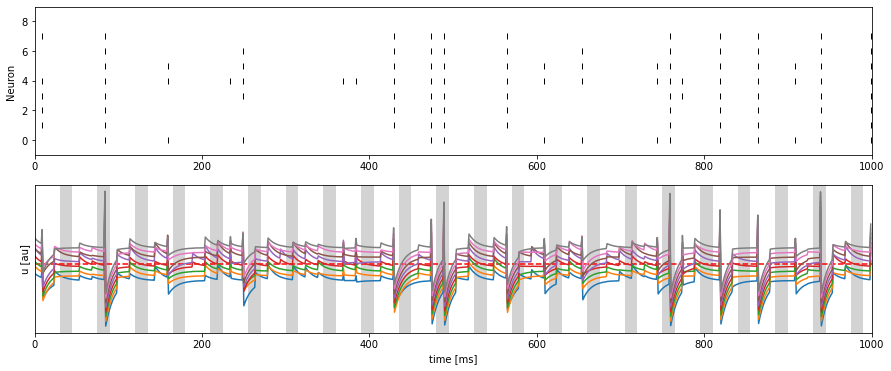

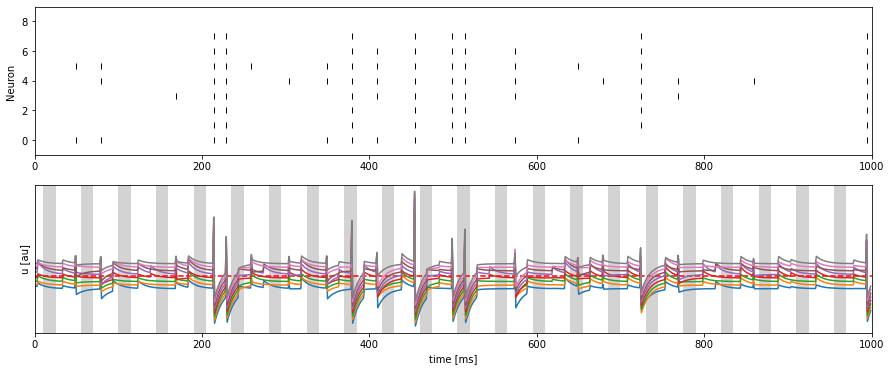

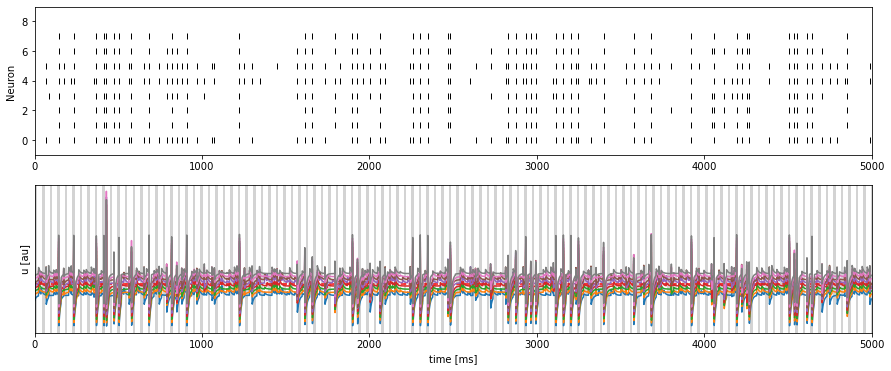

(<AxesSubplot:ylabel='Neuron '>,
 <AxesSubplot:xlabel='time [ms]', ylabel='u [au]'>)

In [21]:
pat_times = np.load('./sequences/massive_runs/1/pat_sequences/all_nums/training/0/pat_all_nums.npy')

sv_utils.plotLIF(U=Uprobe_fc[0:1000], S=Sprobe_fc[0:1000], pat_times=pat_times[0:1000], th=th)
sv_utils.plotLIF(U=Uprobe_fc[2000:3000], S=Sprobe_fc[2000:3000], pat_times=pat_times[2000:3000], th=th)
sv_utils.plotLIF(U=Uprobe_fc[30000:35000], S=Sprobe_fc[30000:35000], pat_times=pat_times[30000:35000], th=th)

# Entranamos a la Single-Neuron con la salida de la FC

In [33]:
#pat_times = np.load('./sequences/p_18/training/pat_p_18.npy')
Sin = torch.tensor(Sprobe_fc).float()
T = Sin.shape[0]
N_out = 1
N_in = Sin.shape[1]
th = 7.

singleNeuron = STDPLIFDensePopulation(in_channels=N_in, out_channels=N_out,
                                        weight=0.70, alpha=float(np.exp(-1e-3/10e-3)),
                                        beta=float(np.exp(-1e-3/2e-5)), delay=0,
                                                th=th, a_plus=.00010125, a_minus=.000125625,
                                        w_max=1.)


# Pre-procesamos PSpikes y NSpikes
dt_ltp = 20  # Cantidad de timesteps que miro hacia atras
dt_ltd = 70  # Cantidad de timesteps que miro hacia delante
PSpikes = preSpikes(T, dt_ltp, torch.zeros(T, N_in), Sin)
NSpikes = nextSpikes(T, dt_ltd, torch.zeros(T, N_in), Sin)

# Realizamos el entrenamiento STDP
Uprobe = np.empty([T, N_out])
Iprobe = np.empty([T, N_out])
Sprobe = np.empty([T, N_out])

n = 0
t = 0
c_l = 1.
while (c_l > 0.01) and (t < 300000):
    state = singleNeuron.forward(Sin[n].unsqueeze(0), PSpikes[n], NSpikes[n-1])
    Uprobe[n] = state.U.data.numpy()
    Iprobe[n] = state.I.data.numpy()
    Sprobe[n] = state.S.data.numpy()
    n += 1
    if n >= T:
        n = 0
    c_l = convergence_level(singleNeuron.fc_layer.weight[0])
    t += 1
    if (t % 500) == 0:
        print("iter: " + str(t) + " convergence: " + str(c_l))
        

# Una vez finalizado el entrenamiento, obtenemos la salida sin entrenear
Uprobe = np.empty([T, N_out])
Iprobe = np.empty([T, N_out])
Sprobe = np.empty([T, N_out])
for n in range(T):
    state = singleNeuron.forward_no_learning(Sin[n].unsqueeze(0))
    Uprobe[n] = state.U.data.numpy()
    Iprobe[n] = state.I.data.numpy()
    Sprobe[n] = state.S.data.numpy()


iter: 500 convergence: 0.10567132825077641
iter: 1000 convergence: 0.10545701708900213
iter: 1500 convergence: 0.10531405191796006
iter: 2000 convergence: 0.10502790302421383
iter: 2500 convergence: 0.10481310012119982
iter: 3000 convergence: 0.1046698071226646
iter: 3500 convergence: 0.10452644127357535
iter: 4000 convergence: 0.10416770792967833
iter: 4500 convergence: 0.10402408710364996
iter: 5000 convergence: 0.10388039342706756
iter: 5500 convergence: 0.1038085192698186
iter: 6000 convergence: 0.10352084051443766
iter: 6500 convergence: 0.10337689186091614
iter: 7000 convergence: 0.103088776002211
iter: 7500 convergence: 0.10287249787547781
iter: 8000 convergence: 0.10251167007815232
iter: 8500 convergence: 0.10222268001279877
iter: 9000 convergence: 0.1018610326467404
iter: 9500 convergence: 0.1017886485356132
iter: 10000 convergence: 0.10149892996471932
iter: 10500 convergence: 0.10113637196673553
iter: 11000 convergence: 0.10091861861628315
iter: 11500 convergence: 0.100482620

iter: 92500 convergence: 0.05927160328507508
iter: 93000 convergence: 0.059036862620051256
iter: 93500 convergence: 0.05889588162624815
iter: 94000 convergence: 0.05875479818635343
iter: 94500 convergence: 0.0586136123003671
iter: 95000 convergence: 0.05851943146188088
iter: 95500 convergence: 0.05823661575684458
iter: 96000 convergence: 0.05795339026744184
iter: 96500 convergence: 0.05766975499367266
iter: 97000 convergence: 0.05748043715317852
iter: 97500 convergence: 0.05748043715317852
iter: 98000 convergence: 0.057338329252367704
iter: 98500 convergence: 0.05724353373733182
iter: 99000 convergence: 0.057012346255484125
iter: 99500 convergence: 0.056869900903262494
iter: 100000 convergence: 0.05682239635339048
iter: 100500 convergence: 0.056679814406380036
iter: 101000 convergence: 0.05644195017004794
iter: 101500 convergence: 0.05625145388879904
iter: 102000 convergence: 0.056108462157422156
iter: 102500 convergence: 0.05591764715499936
iter: 103000 convergence: 0.0555354707709985

iter: 181500 convergence: 0.022277091801335747
iter: 182000 convergence: 0.022056322389314875
iter: 182500 convergence: 0.02178010450905976
iter: 183000 convergence: 0.021503602056327953
iter: 183500 convergence: 0.02122681503111945
iter: 184000 convergence: 0.021060606221205536
iter: 184500 convergence: 0.0208388351140667
iter: 185000 convergence: 0.020561365114914132
iter: 185500 convergence: 0.020228025480261813
iter: 186000 convergence: 0.019894276061243055
iter: 186500 convergence: 0.019671548790582527
iter: 187000 convergence: 0.019337116397619702
iter: 187500 convergence: 0.019113933810996464
iter: 188000 convergence: 0.018946427350588824
iter: 188500 convergence: 0.018667022258594734
iter: 189000 convergence: 0.018443293292816243
iter: 189500 convergence: 0.01838733259412395
iter: 190000 convergence: 0.018051329361089774
iter: 190500 convergence: 0.017434259132797614
iter: 191000 convergence: 0.017153317349429376
iter: 191500 convergence: 0.017040860955788606
iter: 192000 conve

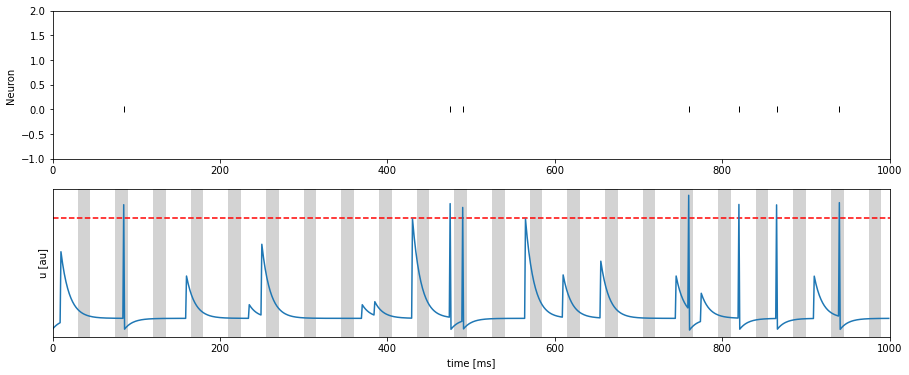

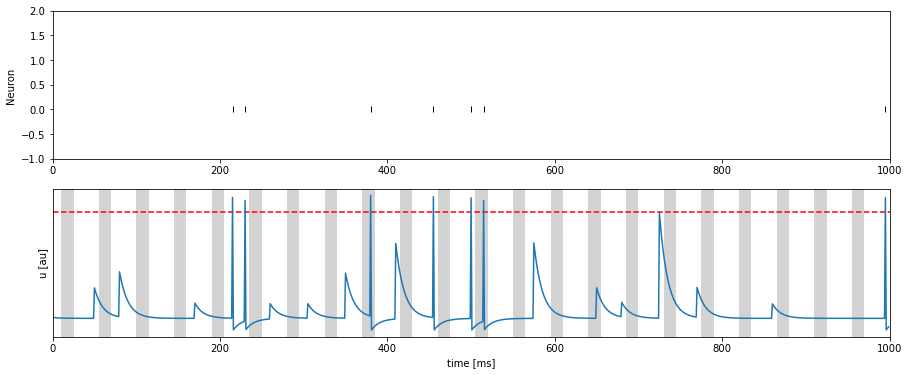

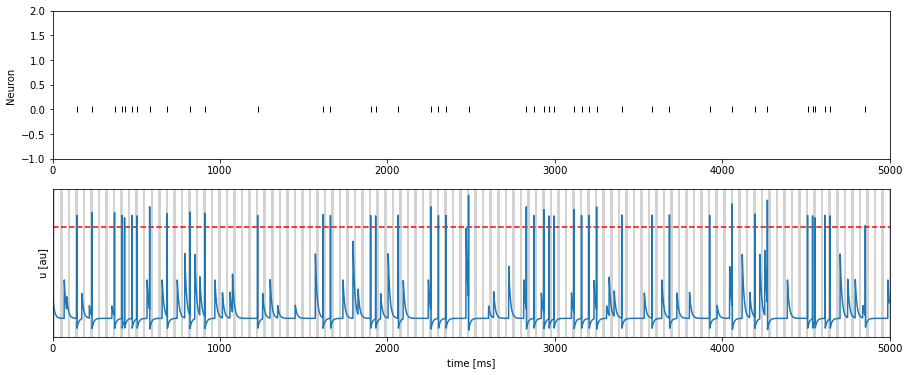

(<AxesSubplot:ylabel='Neuron '>,
 <AxesSubplot:xlabel='time [ms]', ylabel='u [au]'>)

In [34]:
pat_times = np.load('./sequences/massive_runs/1/pat_sequences/all_nums/training/0/pat_all_nums.npy')

sv_utils.plotLIF(U=Uprobe[0:1000], S=Sprobe[0:1000], pat_times=pat_times[0:1000], th=th)
sv_utils.plotLIF(U=Uprobe[2000:3000], S=Sprobe[2000:3000], pat_times=pat_times[2000:3000], th=th)
sv_utils.plotLIF(U=Uprobe[30000:35000], S=Sprobe[30000:35000], pat_times=pat_times[30000:35000], th=th)

# Corremos la secuencia de testing a traves de la FC y Single-Neuron

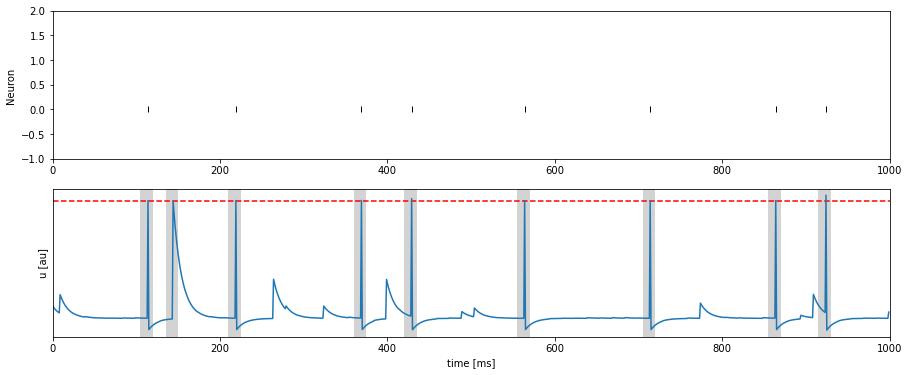

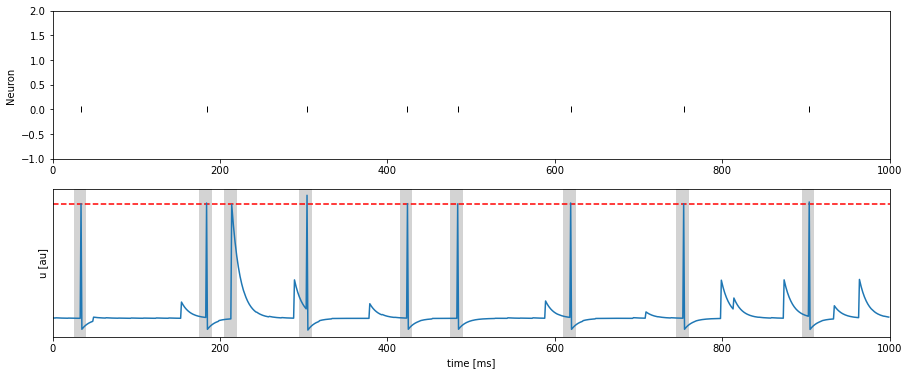

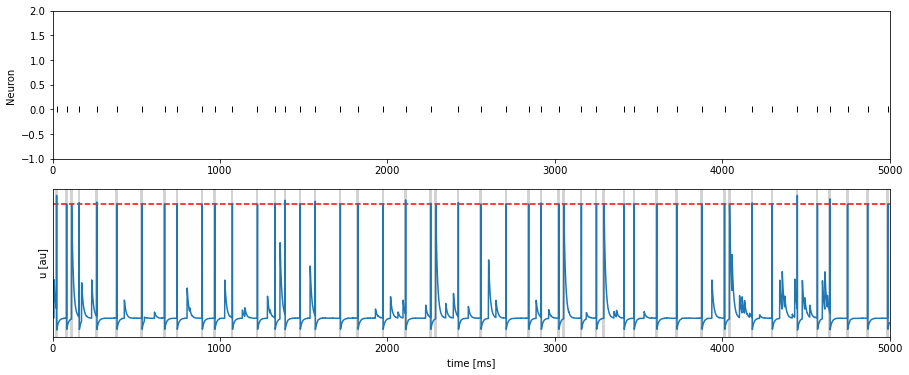

accuracy: 0.9743795036028823
precision: 0.9970760233918129
recall: 0.844059405940594
f1: 0.9142091152815014
fake_alarms: 0.0004775549188156638
missed_alarms: 0.15594059405940594


In [15]:
pat_times = np.load('./sequences/massive_runs/1/pat_sequences/all_nums_5/testing/0/pat_test_all_nums.npy')
Sin_tmp = torch.load('./sequences/massive_runs/1/last_layer_results/all_nums_5/testing/0/layer_5_conv.pt')
T = Sin_tmp.shape[0]
N_out = 1
N_in = Sin_tmp.shape[1]
th = 3.

Sin = Sin_tmp.clone().detach()

# Realizamos el entrenamiento STDP
Uprobe = np.empty([T, N_out])
Iprobe = np.empty([T, N_out])
Sprobe = np.empty([T, N_out])
for n in range(T):
    state = singleNeuron.forward_no_learning(Sin[n].unsqueeze(0))
    Uprobe[n] = state.U.data.numpy()
    Iprobe[n] = state.I.data.numpy()
    Sprobe[n] = state.S.data.numpy()
    
sv_utils.plotLIF(U=Uprobe[0:1000], S=Sprobe[0:1000], pat_times=pat_times[0:1000], th=th)
sv_utils.plotLIF(U=Uprobe[2000:3000], S=Sprobe[2000:3000], pat_times=pat_times[2000:3000], th=th)
sv_utils.plotLIF(U=Uprobe[30000:35000], S=Sprobe[30000:35000], pat_times=pat_times[30000:35000], th=th)


accuracy, precision, recall, f1, fake_alarms, missed_alarms = get_metrics(T - 15, pat_times, Sprobe)
print("accuracy: " + str(accuracy))
print("precision: " + str(precision))
print("recall: " + str(recall))
print("f1: " + str(f1))
print("fake_alarms: " + str(fake_alarms))
print("missed_alarms: " + str(missed_alarms))

# Parallel Architecture

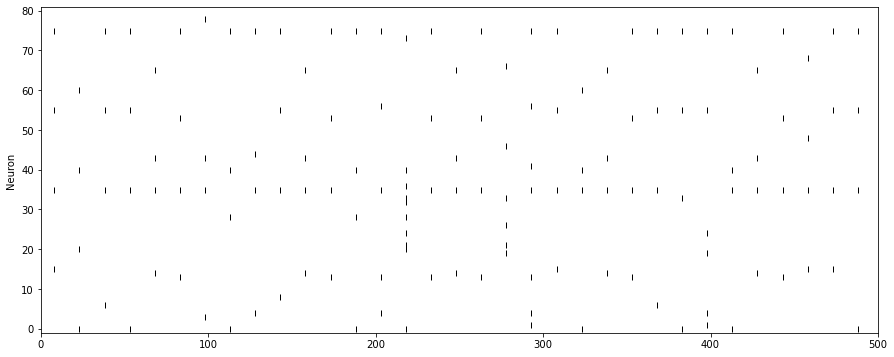

torch.Size([89970, 80])
Sequential Spikes: 25794


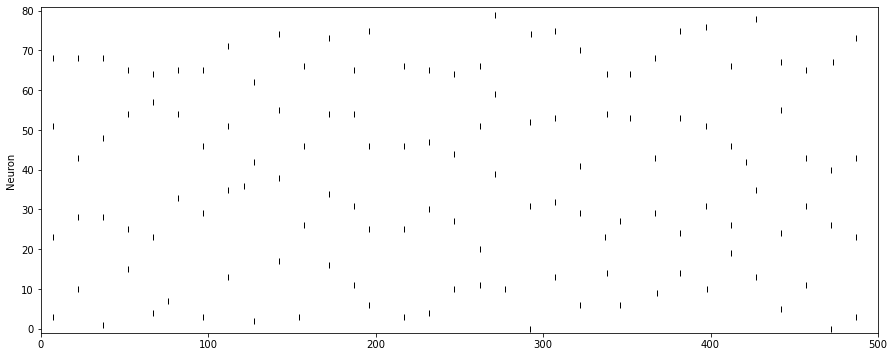

torch.Size([89970, 80])
Parallel Spikes: 23914


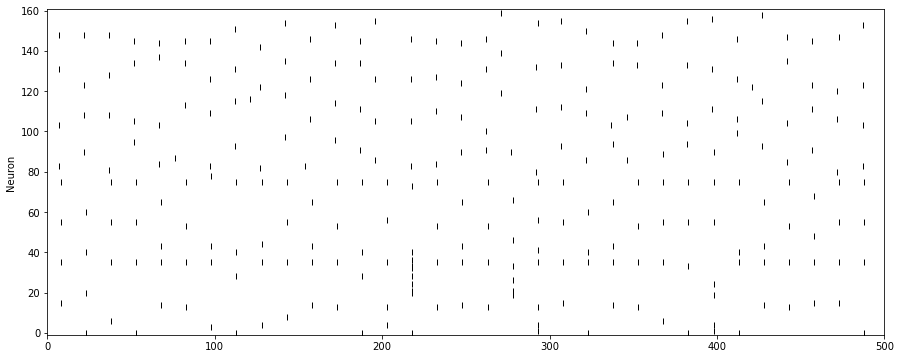

torch.Size([89970, 160])
Combined Spikes: 49708


In [7]:
Sin_out_seq = torch.load('../cleanDSNN/results/old_results/massive_runs/18/0_0_0/p_18/training/0/layer_5_conv.pt')
sv_utils.plotLIF(U=None, S=Sin_out_seq[:500].data.numpy())
print(Sin_out_seq.shape)
print("Sequential Spikes: " + str(np.count_nonzero(Sin_out_seq)))

Sin_out_par = torch.load('../cleanDSNN/results/old_results/massive_runs/18/15_0_0/p_18/training/0/layer_5_conv.pt')
sv_utils.plotLIF(U=None, S=Sin_out_par[:500].data.numpy())
print(Sin_out_par.shape)
print("Parallel Spikes: " + str(np.count_nonzero(Sin_out_par)))

combined_out = torch.cat((Sin_out_seq, Sin_out_par), 1)
sv_utils.plotLIF(U=None, S=combined_out[:500].data.numpy())
print(combined_out.shape)
print("Combined Spikes: " + str(np.count_nonzero(combined_out)))

# Realizamos el entrenamiento

In [8]:
Sin = combined_out.clone().detach()
T = Sin.shape[0]
N_out = 1
N_in = Sin.shape[1]
th = 4.

singleNeuron = STDPLIFDensePopulation(in_channels=N_in, out_channels=N_out,
                                        weight=0.70, alpha=float(np.exp(-1e-3/10e-3)),
                                        beta=float(np.exp(-1e-3/2e-5)), delay=0,
                                        th=th, a_plus=.009125, a_minus=.0125625,
                                        w_max=1.)


# Pre-procesamos PSpikes y NSpikes
dt_ltp = 20  # Cantidad de timesteps que miro hacia atras
dt_ltd = 70  # Cantidad de timesteps que miro hacia delante
PSpikes = preSpikes(T, dt_ltp, torch.zeros(T, N_in), Sin)
NSpikes = nextSpikes(T, dt_ltd, torch.zeros(T, N_in), Sin)

# Realizamos el entrenamiento STDP
Uprobe = np.empty([T, N_out])
Iprobe = np.empty([T, N_out])
Sprobe = np.empty([T, N_out])

n = 0
t = 0
c_l = 1.
while (c_l > 0.01) and (t < 300000):
    state = singleNeuron.forward(Sin[n].unsqueeze(0), PSpikes[n], NSpikes[n-1])
    Uprobe[n] = state.U.data.numpy()
    Iprobe[n] = state.I.data.numpy()
    Sprobe[n] = state.S.data.numpy()
    n += 1
    if n >= T:
        n = 0
    c_l = convergence_level(singleNeuron.fc_layer.weight[0])
    t += 1
    if (t % 500) == 0:
        print("iter: " + str(t) + " convergence: " + str(c_l))

iter: 500 convergence: 0.21074298005959421
iter: 1000 convergence: 0.2123019979648789
iter: 1500 convergence: 0.21475716338423662
iter: 2000 convergence: 0.21648161845470265
iter: 2500 convergence: 0.21821598770958683
iter: 3000 convergence: 0.22000093633663864
iter: 3500 convergence: 0.22181764848081773
iter: 4000 convergence: 0.2227742497297167
iter: 4500 convergence: 0.22342506126095224
iter: 5000 convergence: 0.22375848396908263
iter: 5500 convergence: 0.22322840244360984
iter: 6000 convergence: 0.22315553911462188
iter: 6500 convergence: 0.22255877394651308
iter: 7000 convergence: 0.22162514827728907
iter: 7500 convergence: 0.22217756072694578
iter: 8000 convergence: 0.2217482067517241
iter: 8500 convergence: 0.2221017310989856
iter: 9000 convergence: 0.22237026173448218
iter: 9500 convergence: 0.22243926586350682
iter: 10000 convergence: 0.22233617308421544
iter: 10500 convergence: 0.22238591870033572
iter: 11000 convergence: 0.22243109081555476
iter: 11500 convergence: 0.2221298

iter: 92500 convergence: 0.10794037182124727
iter: 93000 convergence: 0.10745875058658498
iter: 93500 convergence: 0.10756388370103058
iter: 94000 convergence: 0.10737888182931321
iter: 94500 convergence: 0.1071484214428644
iter: 95000 convergence: 0.10721015874337599
iter: 95500 convergence: 0.10703400950213549
iter: 96000 convergence: 0.10704046452498325
iter: 96500 convergence: 0.10713073782229592
iter: 97000 convergence: 0.10671330604135428
iter: 97500 convergence: 0.10688533854215825
iter: 98000 convergence: 0.1066481279197498
iter: 98500 convergence: 0.10637578013352647
iter: 99000 convergence: 0.1062228078867068
iter: 99500 convergence: 0.10595332924926085
iter: 100000 convergence: 0.10539269244014873
iter: 100500 convergence: 0.1055714034731274
iter: 101000 convergence: 0.10560204294281517
iter: 101500 convergence: 0.1051563087463987
iter: 102000 convergence: 0.10502406024745388
iter: 102500 convergence: 0.10465688246471487
iter: 103000 convergence: 0.10422968386306279
iter: 10

iter: 182000 convergence: 0.0825188936309936
iter: 182500 convergence: 0.08221962040693957
iter: 183000 convergence: 0.0817893281561336
iter: 183500 convergence: 0.08165245999473433
iter: 184000 convergence: 0.08196249400741885
iter: 184500 convergence: 0.08169471830647114
iter: 185000 convergence: 0.08155988359850411
iter: 185500 convergence: 0.08179634054896165
iter: 186000 convergence: 0.08172610299868013
iter: 186500 convergence: 0.08136820950257012
iter: 187000 convergence: 0.0813124048303327
iter: 187500 convergence: 0.08111041558002421
iter: 188000 convergence: 0.08124216733897374
iter: 188500 convergence: 0.08151881137408565
iter: 189000 convergence: 0.08134163336192554
iter: 189500 convergence: 0.08139510789412864
iter: 190000 convergence: 0.08171643195806118
iter: 190500 convergence: 0.08169191591575589
iter: 191000 convergence: 0.08182682252176961
iter: 191500 convergence: 0.081419927324297
iter: 192000 convergence: 0.08099376084011842
iter: 192500 convergence: 0.08082735116

iter: 271500 convergence: 0.07233837346174037
iter: 272000 convergence: 0.07188426096158222
iter: 272500 convergence: 0.07157363610143719
iter: 273000 convergence: 0.0713617513269465
iter: 273500 convergence: 0.0716061240079046
iter: 274000 convergence: 0.07177980894692443
iter: 274500 convergence: 0.07154270633677366
iter: 275000 convergence: 0.07155307477649683
iter: 275500 convergence: 0.07184940437322387
iter: 276000 convergence: 0.07178168009288288
iter: 276500 convergence: 0.07140965905626032
iter: 277000 convergence: 0.0713058934247058
iter: 277500 convergence: 0.07113085604012802
iter: 278000 convergence: 0.07118000720529918
iter: 278500 convergence: 0.07148646197864882
iter: 279000 convergence: 0.07149374840732765
iter: 279500 convergence: 0.07141946354961029
iter: 280000 convergence: 0.07182734133091426
iter: 280500 convergence: 0.07175790239252772
iter: 281000 convergence: 0.07197530326170494
iter: 281500 convergence: 0.07146012374235691
iter: 282000 convergence: 0.071187735

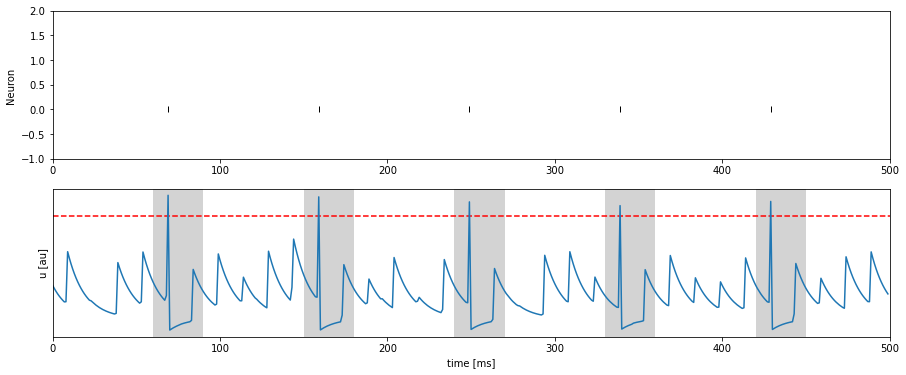

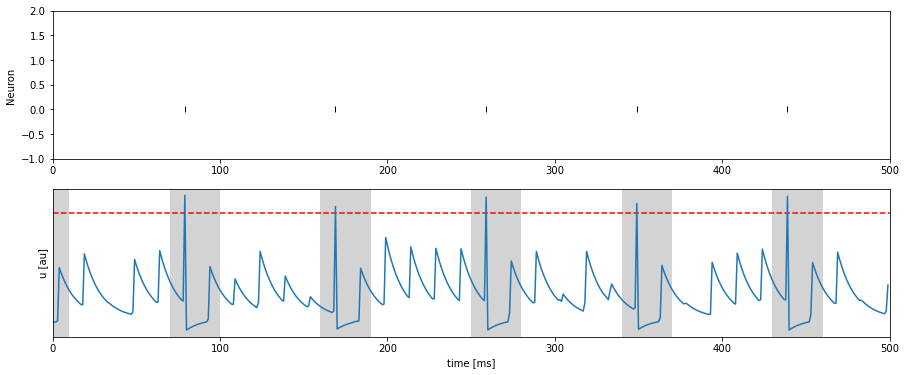

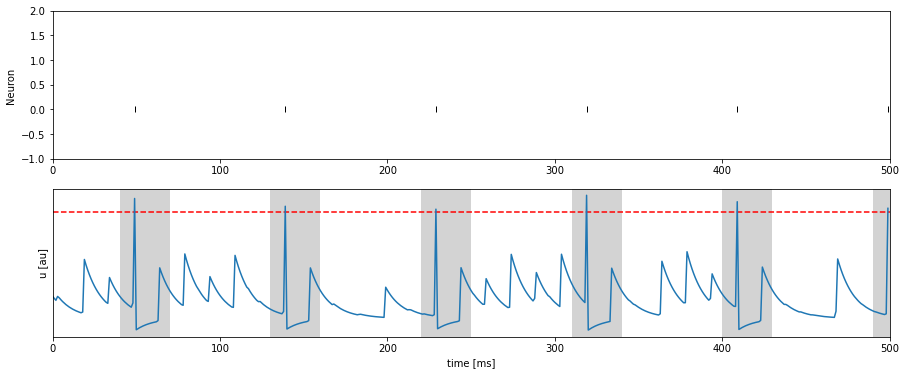

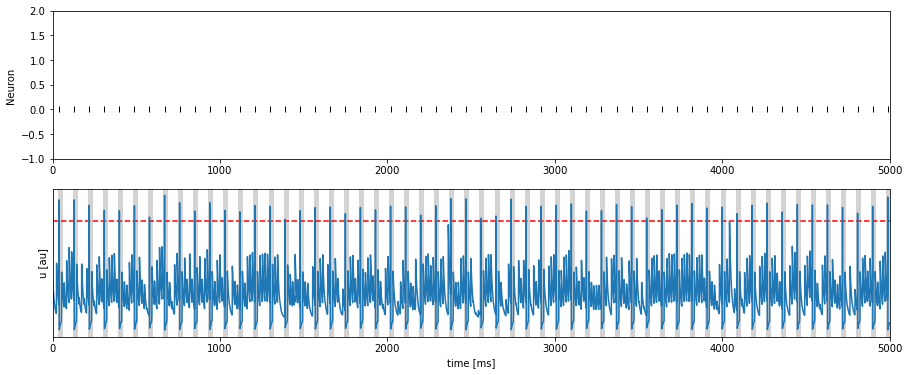

accuracy: 0.9981992797118847
precision: 0.9930278884462151
recall: 0.997997997997998
f1: 0.9955067398901648
fake_alarms: 0.0017504376094023505
missed_alarms: 0.002002002002002002
fake_spikes_numbers: [(18, 25, 0, 47), (10, 26, 0, 182), (14, 19, 0, 196), (14, 21, 1, 324), (12, 22, 1, 375), (22, 14, 0, 478), (16, 21, 0, 515)]


In [9]:
pat_times = np.load('./sequences/massive_runs/18/p_18/training/0/pat_p_18.npy')
pat_number = np.load('./sequences/massive_runs/18/p_18/training/0/data_p_18.npy')
Sin_tmp_seq = torch.load('../cleanDSNN/results/old_results/massive_runs/18/0_0_0/p_18/training/0/layer_5_conv.pt')
Sin_tmp_par = torch.load('../cleanDSNN/results/old_results/massive_runs/18/15_0_0/p_18/training/0/layer_5_conv.pt')

Sin_tmp = torch.cat((Sin_tmp_seq, Sin_tmp_par), 1)
T = Sin_tmp.shape[0]
N_out = 1
N_in = Sin_tmp.shape[1]
th = 4.

Sin = Sin_tmp.clone().detach()

# Realizamos el entrenamiento STDP
Uprobe = np.empty([T, N_out])
Iprobe = np.empty([T, N_out])
Sprobe = np.empty([T, N_out])
for n in range(T):
    state = singleNeuron.forward_no_learning(Sin[n].unsqueeze(0))
    Uprobe[n] = state.U.data.numpy()
    Iprobe[n] = state.I.data.numpy()
    Sprobe[n] = state.S.data.numpy()
    

sv_utils.plotLIF(U=Uprobe[0:500], S=Sprobe[0:500], pat_times=pat_times[0:500], th=th)
sv_utils.plotLIF(U=Uprobe[8000:8500], S=Sprobe[8000:8500], pat_times=pat_times[8000:8500], th=th)
sv_utils.plotLIF(U=Uprobe[20000:20500], S=Sprobe[20000:20500], pat_times=pat_times[20000:20500], th=th)
sv_utils.plotLIF(U=Uprobe[30000:35000], S=Sprobe[30000:35000], pat_times=pat_times[30000:35000], th=th)


accuracy, precision, recall, f1, fake_alarms, missed_alarms, fake_spikes_numbers = get_metrics_long_pat(T - 15, pat_times, Sprobe, 30, pat_number)
print("accuracy: " + str(accuracy))
print("precision: " + str(precision))
print("recall: " + str(recall))
print("f1: " + str(f1))
print("fake_alarms: " + str(fake_alarms))
print("missed_alarms: " + str(missed_alarms))
print("fake_spikes_numbers: " + str(fake_spikes_numbers))